_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [1]:
# Import relational data
import pandas as pd
trainval = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert trainval.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

In [2]:
def merge(X):
    X = X.copy()
    X = X.merge(store)
    return X

trainval = merge(trainval)
test = merge(test)

In [3]:
trainval.shape, test.shape

((78400, 16), (78400, 16))

In [4]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(
    trainval, random_state=42
)

In [5]:
train.shape, val.shape, test.shape

((58800, 16), (19600, 16), (78400, 16))

In [6]:
def wrangle(X):
    X = X.copy()
    
    # Drop Store because our goal is to predict unknown stores
    X = X.drop(columns='Store')
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [7]:
train.shape, val.shape, test.shape

((58800, 15), (19600, 15), (78400, 15))

In [8]:
train.head()

,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
36471,4,2014-03-27,5576,686,0,0,d,c,2780.0,6.0,2015.0,0,NaN,NaN,NaN
58197,2,2014-12-23,12190,1305,0,1,a,a,17570.0,NaN,NaN,0,NaN,NaN,NaN
30201,2,2014-03-25,3642,486,0,0,c,c,1540.0,NaN,NaN,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
17698,3,2014-02-05,8995,1150,1,0,a,c,340.0,9.0,2012.0,1,40.0,2012.0,"Jan,Apr,Jul,Oct"
65968,2,2015-03-17,10352,1035,1,0,a,a,2820.0,9.0,2009.0,0,NaN,NaN,NaN


In [10]:
import numpy as np
target = 'Sales'
y_train = train[target]
y_val = val[target]
y_pred = np.full_like(y_val, fill_value=y_train.mean())

#print('Validation RMSLE, Mean Baseline:', rmsle(y_val, y_pred))

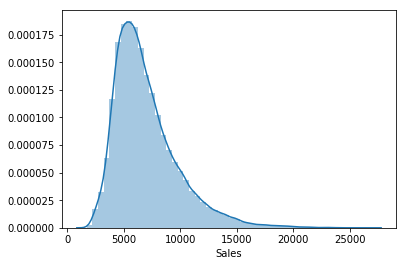

In [11]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

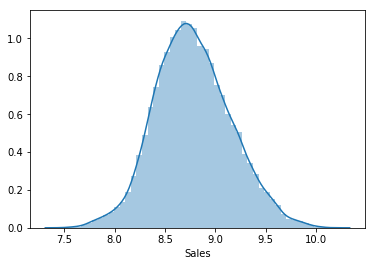

In [12]:
y_train_log = np.log1p(y_train)
sns.distplot(y_train_log);

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [13]:
train.describe()

,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,58800.000000,58800.000000,58800.000000,58800.000000,58800.000000,58800.000000,48763.000000,48763.000000,58800.000000,11772.000000,11772.000000
mean,3.506650,6985.294711,825.836531,0.449677,0.194558,4714.858333,7.141275,2010.967168,0.200204,24.418875,2011.597944
std,1.709081,2825.195842,316.179133,0.497465,0.395863,8876.796006,3.226152,2.448721,0.400156,13.581433,0.966435
min,1.000000,1712.000000,206.000000,0.000000,0.000000,30.000000,1.000000,2006.000000,0.000000,1.000000,2010.000000
25%,2.000000,4998.000000,598.000000,0.000000,0.000000,720.000000,4.000000,2009.000000,0.000000,14.000000,2011.000000
50%,3.000000,6362.000000,757.000000,0.000000,0.000000,1940.000000,9.000000,2011.000000,0.000000,22.000000,2012.000000
75%,5.000000,8304.250000,994.000000,1.000000,0.000000,4030.000000,9.000000,2013.000000,0.000000,35.000000,2012.000000
max,6.000000,26914.000000,3360.000000,1.000000,1.000000,48330.000000,12.000000,2015.000000,1.000000,48.000000,2013.000000


In [28]:
features = ['Customers', 'DayOfWeek', 'Promo']


In [29]:
X_train = train[features]
X_val = val[features]

In [31]:
target = 'Sales'
y_train = train[target]
y_val = val[target]
y_pred = np.full_like(y_val, fill_value=y_train.mean())


In [32]:
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

In [47]:
import numpy as np
from sklearn.metrics import mean_squared_log_error, mean_squared_error
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_val)
print('RMSE', rmse(y_val_log, y_pred_log))
print('RMSLE', rmsle(y_val_log, y_pred_log))

RMSE 0.17167897054491466
RMSLE 0.01749467535275828


In [49]:
from xgboost import XGBRegressor

# Make pipeline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=1000, n_job=-1)
)

# Fit
pipeline.fit(X_train, y_train_log)

# Validate
y_pred_log = pipeline.predict(X_val)
print('Validation Error', rmse(y_val_log, y_pred_log))

/Users/ericchiyembekeza/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:31:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation Error 0.15829431963776353


## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

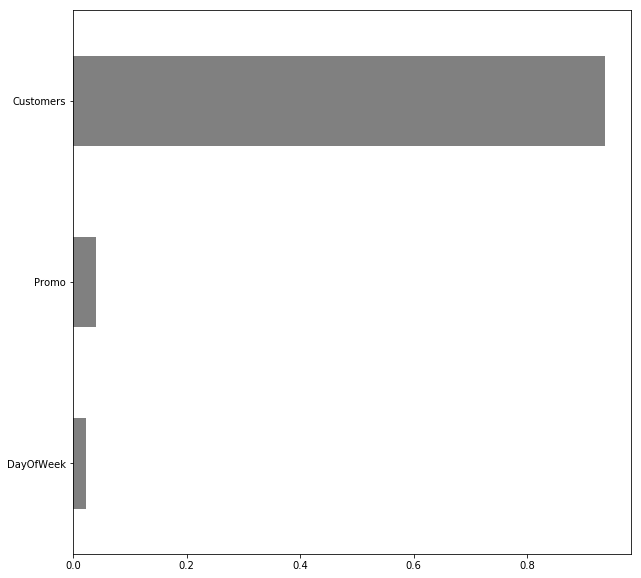

In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
rf = pipeline.named_steps['randomforestregressor']
importances = pd.Series(rf.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

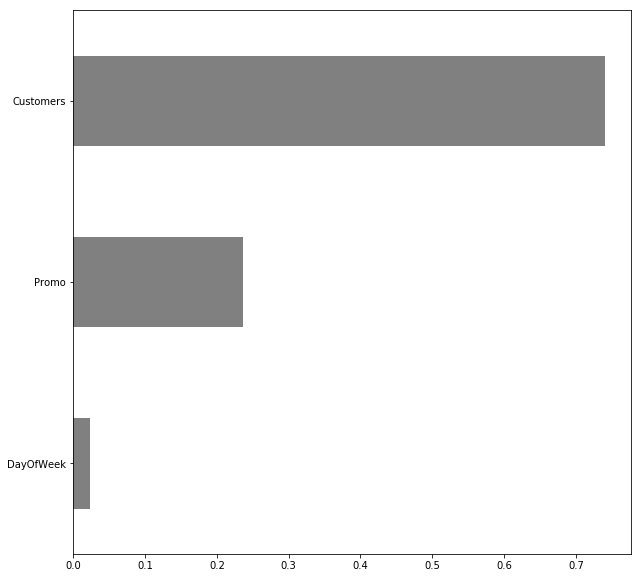

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
xgb = pipeline.named_steps['xgbregressor']
importances = pd.Series(xgb.feature_importances_, X_train.columns)
importances.sort_values().plot.barh(color='grey');

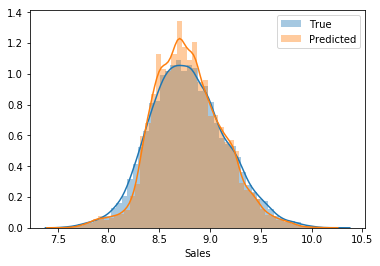

In [44]:
import matplotlib.pyplot as plt
sns.distplot(y_val_log, label='True')
sns.distplot(y_pred_log, label='Predicted')
plt.legend();